In [90]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline

In [2]:
h, v = np.meshgrid(np.arange(2)*2, np.arange(2)*2)
p1 = np.vstack([h.ravel(), v.ravel()]).T

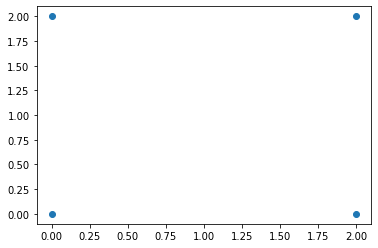

In [3]:
plt.scatter(*p1.T)

In [4]:
H = np.random.rand(3, 3)
H = H / H[2, 2]
H

array([[0.24654018, 0.84053727, 0.78254748],
       [0.29830552, 0.83488629, 0.38139241],
       [0.72156215, 0.03908156, 1.        ]])

In [5]:
def to_hom(points):
    ones = np.ones((points.shape[0], 1))
    return np.concatenate((points, ones), axis=1)

In [6]:
p1h = to_hom(p1)

In [7]:
p2h = p1h @ H.T

In [8]:
p2h.shape

(4, 3)

In [9]:
p2 = (p2h / p2h[:, 2][:, None])[:, :2]

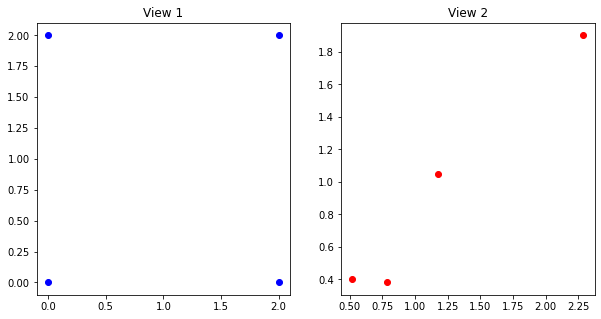

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(p1[:, 0], p1[:, 1], c='blue')
plt.title('View 1')
plt.subplot(1, 2, 2)
plt.scatter(p2[:, 0], p2[:, 1], c='red')
plt.title('View 2')
plt.show()

In [11]:
Hest, _ = cv2.findHomography(p1, p2)

In [12]:
H, Hest

(array([[0.24654018, 0.84053727, 0.78254748],
        [0.29830552, 0.83488629, 0.38139241],
        [0.72156215, 0.03908156, 1.        ]]),
 array([[0.24654021, 0.84053749, 0.78254747],
        [0.29830557, 0.83488644, 0.38139242],
        [0.72156225, 0.03908164, 1.        ]]))

In [14]:
num_points = p1.shape[0]
A = np.zeros((2 * num_points, 9))
    
for i in range(num_points):
    x, y = p1[i]
    u, v = p2[i]
        
    A[2*i] = [-x, -y, -1, 0, 0, 0, u*x, u*y, u]
    A[2*i+1] = [0, 0, 0, -x, -y, -1, v*x, v*y, v]

In [15]:
cov = A.T @ A
eigenvalues, eigenvectors = np.linalg.eig(cov)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices].T

In [16]:
eigenvectors.shape

(9, 9)

In [17]:
h = eigenvectors[8]
h = h / h[8]
h

array([0.24654018, 0.84053727, 0.78254748, 0.29830552, 0.83488629,
       0.38139241, 0.72156215, 0.03908156, 1.        ])

In [18]:
eigenvalues

array([ 7.14260887e+01,  1.50555620e+01,  1.49142556e+01,  4.00073644e+00,
        2.42821064e+00,  1.09340331e+00,  5.04705261e-01,  5.17746476e-03,
       -1.77199049e-15])

In [19]:
J = np.zeros((9, 9))
for k in range(1, 9):
    J += (eigenvectors[k].reshape(-1, 1) * eigenvectors[k].T.reshape(1, -1)) / eigenvalues[k]
J *= -1

In [20]:
J

array([[8.94825271e+12, 3.05075625e+13, 2.84028047e+13, 1.08270918e+13,
        3.03024584e+13, 1.38427566e+13, 2.61893233e+13, 1.41847729e+12,
        3.62953119e+13],
       [3.05075625e+13, 1.04010403e+14, 9.68345852e+13, 3.69131482e+13,
        1.03311135e+14, 4.71945503e+13, 8.92880926e+13, 4.83605972e+12,
        1.23742761e+14],
       [2.84028047e+13, 9.68345852e+13, 9.01538369e+13, 3.43664604e+13,
        9.61835609e+13, 4.39385348e+13, 8.31279870e+13, 4.50241346e+12,
        1.15205581e+14],
       [1.08270918e+13, 3.69131482e+13, 3.43664604e+13, 1.31004253e+13,
        3.66649790e+13, 1.67492807e+13, 3.16882206e+13, 1.71631091e+12,
        4.39161348e+13],
       [3.03024584e+13, 1.03311135e+14, 9.61835609e+13, 3.66649790e+13,
        1.02616569e+14, 4.68772587e+13, 8.86878038e+13, 4.80354662e+12,
        1.22910831e+14],
       [1.38427566e+13, 4.71945503e+13, 4.39385348e+13, 1.67492807e+13,
        4.68772587e+13, 2.14144501e+13, 4.05143261e+13, 2.19435420e+12,
        5.6

In [21]:
h

array([0.24654018, 0.84053727, 0.78254748, 0.29830552, 0.83488629,
       0.38139241, 0.72156215, 0.03908156, 1.        ])

In [54]:
def get_fio(h, x, y, X, sigma_pt, sigma_w):
    sigma_pt = sigma_pt**2
    sigwa_w = sigma_w.T @ sigma_w
    
    ft = sigma_pt * (h[0]**2 + h[1]**2 - 2 * X * (h[0] * h[6] + h[1] * h[7]))
    st = (2 * sigma_w) * (x * h[6] * h[8] + x * y * h[6] * h[7] + y * h[7] * h[8])
    tt = (sigma_pt * X**2 + x**2 * sigwa_w) * h[6]**2
    kt = (sigma_pt * X**2 + y**2 * sigwa_w) * h[7]**2
    jt = sigma_w * h[8]**2
    
    return ft + st + tt + kt + jt

def get_fie(h, x, y, Y, sigma_pt, sigma_w):
    sigma_pt = sigma_pt**2
    sigwa_w = sigma_w.T @ sigma_w
    
    ft = sigma_pt * (h[3]**2 + h[4]**2 - 2 * Y * (h[3] * h[6] + h[5] * h[7]))
    st = (2 * sigma_w) * (x * h[6] * h[8] + x * y * h[6] * h[7] + y * h[7] * h[8])
    tt = (sigma_pt * Y**2 + x**2 * sigwa_w) * h[6]**2
    kt = (sigma_pt * Y**2 + y**2 * sigwa_w) * h[7]**2
    jt = sigma_w * h[8]**2
    
    return ft + st + tt + kt + jt

def get_fioe(h, X, Y, sigma_pt):
    sigma_pt = sigma_pt**2
    ft = (h[0] - X * h[6]) * (h[3] - Y * h[6])
    st = (h[1] - X * h[7]) * (h[4] - Y * h[7])
    
    return sigma_pt * (ft + st)

def get_S(A, h, p1, p2, sigma_pt, sigma_W):
    '''
    A: [9, 9]
    '''
    
    n = 9
    
    S = np.zeros((9, 9))
    for i in range(1, 5):
        x1 = p1[i - 1]
        x2 = p2[i - 1]
        x, y = x1
        X, Y = x2
        
        fio = get_fio(h, x, y, X, sigma_pt, sigma_W)
        fie = get_fie(h, x, y, Y, sigma_pt, sigma_W)
        fioe = get_fioe(h, X, Y, sigma_pt)
        
        a1 = A[2*i - 2][None]
        ft = a1.T @ a1 * fio
        
        a2 = A[2*i - 1][None]
        st = a2.T @ a2 * fie
        
        tt = a1.T @ a2 * fioe
        kt = a2.T @ a1 * fioe

        S += (ft + st + tt + kt)
        
    return S

In [56]:
S = get_S(A, h, p1, p2, np.eye(1), np.eye(1))
assert S.shape == (9, 9)

In [58]:
hom_cov = J @ S @ J

In [59]:
hom_cov

array([[ 1.86898233e+13,  6.37198089e+13,  5.93236936e+13,
         2.26140721e+13,  6.32914171e+13,  2.89127592e+13,
         5.47004919e+13,  2.96271135e+12,  7.58084275e+13],
       [-3.29791812e+13, -1.12436971e+14, -1.04679793e+14,
        -3.99037257e+13, -1.11681051e+14, -5.10180920e+13,
        -9.65219096e+13, -5.22786080e+12, -1.33767978e+14],
       [ 3.14931688e+13,  1.07370662e+14,  9.99630155e+13,
         3.81056995e+13,  1.06648803e+14,  4.87192624e+13,
         9.21727187e+13,  4.99229807e+12,  1.27740512e+14],
       [ 1.91277351e+13,  6.52127955e+13,  6.07136770e+13,
         2.31439310e+13,  6.47743662e+13,  2.95901994e+13,
         5.59821514e+13,  3.03212914e+12,  7.75846564e+13],
       [-4.31068371e+13, -1.46965510e+14, -1.36826162e+14,
        -5.21578565e+13, -1.45977453e+14, -6.66853602e+13,
        -1.26163054e+14, -6.83329712e+12, -1.74847107e+14],
       [ 5.56339157e+12,  1.89674478e+13,  1.76588580e+13,
         6.73152100e+12,  1.88399286e+13,  8.606448

In [62]:
def get_B(x_hom):
    B = np.zeros((3, 9))
    B[0, :3] = x_hom
    B[1, 3:6] = x_hom
    B[2, 6:] = x_hom
    
    return B

In [64]:
B = get_B(p1h[0])
B

array([[0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [66]:
up2h = B @ hom_cov @ B.T

In [67]:
up2h

array([[9.99630155e+13, 4.87192624e+13, 1.27740512e+14],
       [1.76588580e+13, 8.60644844e+12, 2.25658616e+13],
       [1.80623469e+14, 8.80309794e+13, 2.30814710e+14]])

In [72]:
Hest = h.reshape((3, 3))
Hest

array([[0.24654018, 0.84053727, 0.78254748],
       [0.29830552, 0.83488629, 0.38139241],
       [0.72156215, 0.03908156, 1.        ]])

In [76]:
uHest = Hest @ np.eye(3) @ Hest.T

In [77]:
uHest

array([[1.37966552, 1.07375501, 0.99329104],
       [1.07375501, 0.93148148, 0.62926704],
       [0.99329104, 0.62926704, 1.5221793 ]])

In [79]:
p1h[0]

array([0., 0., 1.])

In [82]:
def get_J_hom_to_pixel(ph):
    J = np.zeros((2, 3))
    J[0, 0] = ph[2]
    J[0, 2] = -ph[0]
    J[1, 1] = ph[2]
    J[1, 2] = -ph[1]
    
    J = J / (ph[2]**2)
    
    return J

In [83]:
up2 = get_J_hom_to_pixel(p2h[0]) @ uHest @ get_J_hom_to_pixel(p2h[0]).T

In [85]:
up2

array([[0.75722372, 0.6567961 ],
       [0.6567961 , 0.67290259]])

In [119]:
def plot_ellipse(mean, covariance, ax, color = 'r'):
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    ellipse = Ellipse(mean, 2 * np.sqrt(2 * eigenvalues[0]), 2 * np.sqrt(2 * eigenvalues[1]),
                      angle=angle, alpha=0.5, facecolor='none', edgecolor=color)
    ax.add_patch(ellipse)

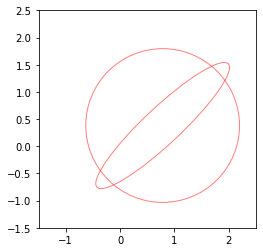

In [120]:
fig, ax = plt.subplots()
plot_ellipse(p2[0], up2, ax)
plot_ellipse(p2[0], np.eye(2), ax)
ax.set_xlim([-1.5, 2.5])
ax.set_ylim([-1.5, 2.5])
ax.set_aspect('equal')
plt.show()

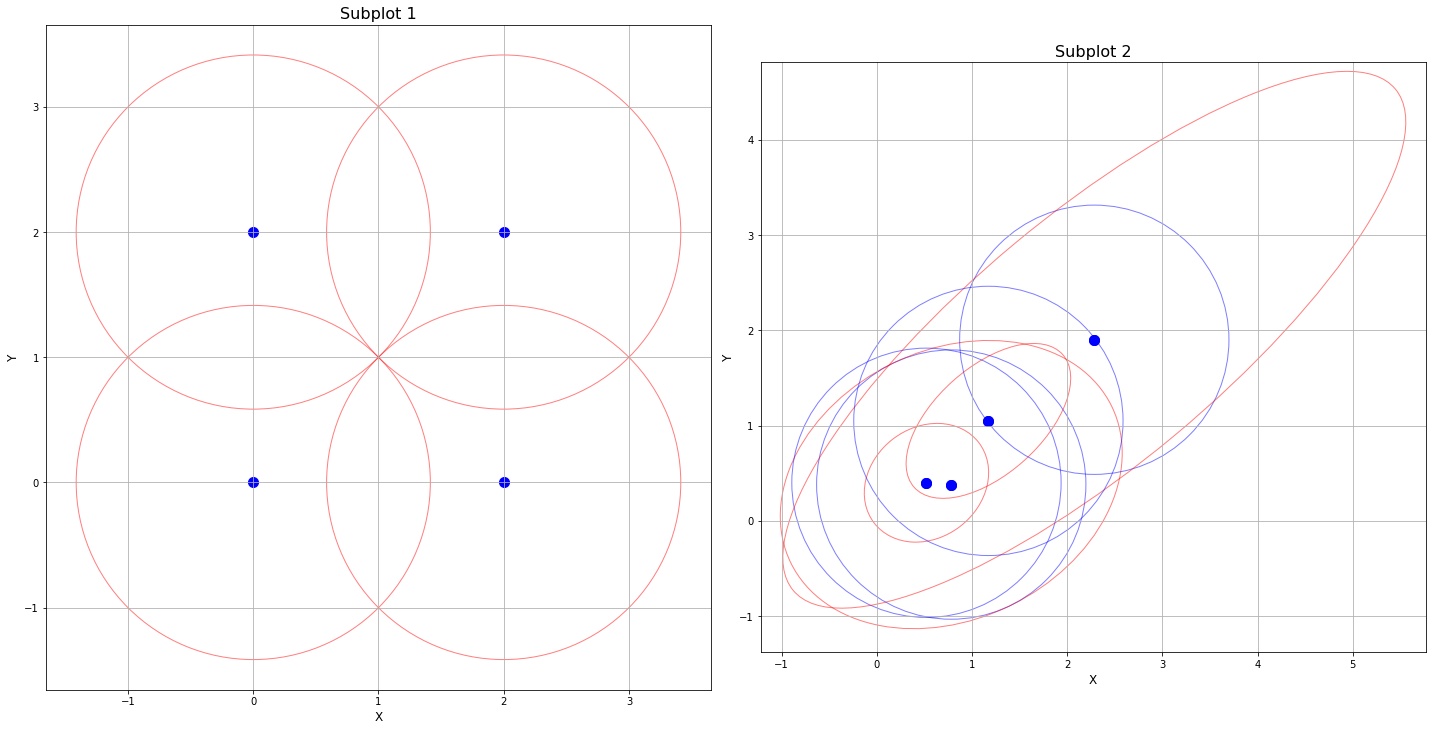

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Subplot 1
for point in p1:
    plot_ellipse(point, np.eye(2), ax[0])
    ax[0].scatter(*point, c='b', marker='o', s=100)

# Subplot 2
ax[1].scatter(*np.array(p2).T, c='b', marker='o', s=100)
for idx, point in enumerate(p2):
    plot_ellipse(point, np.eye(2), ax[1], color='b')
    
    uHest = np.eye(3)  # Example transformation matrix
    up = get_J_hom_to_pixel(p2h[idx]) @ uHest @ get_J_hom_to_pixel(p2h[idx]).T
    plot_ellipse(point, up, ax[1])
    ax[1].scatter(*point, c='b', marker='o', s=100)

# Customize plot appearance
ax[0].set_aspect('equal')
ax[0].set_title('Subplot 1', fontsize=16)
ax[0].set_xlabel('X', fontsize=12)
ax[0].set_ylabel('Y', fontsize=12)
ax[0].grid(True)

ax[1].set_aspect('equal')
ax[1].set_title('Subplot 2', fontsize=16)
ax[1].set_xlabel('X', fontsize=12)
ax[1].set_ylabel('Y', fontsize=12)
ax[1].grid(True)

plt.tight_layout()
plt.show()